In [16]:
# imports and setup
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


In [17]:
# Load features and labels

X_ml = pd.read_csv(r"C:\Projects\BRCA_ML_Project\Data\Output\X_ml_top50.csv", index_col=0)
y_ml = pd.read_csv(r"C:\Projects\BRCA_ML_Project\Data\Output\y_ml_labels.csv", index_col=0).squeeze()  # convert to Series

print(X_ml.shape, y_ml.shape)


(1089, 48) (1089,)


In [18]:
#  --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42, stratify=y_ml
)


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Test Accuracy: 0.9311926605504587


Classification Report:
               precision    recall  f1-score   support

       Basal       1.00      1.00      1.00        37
       HER2E       0.82      0.88      0.85        16
        LumA       0.96      0.91      0.94       113
        LumB       0.82      0.91      0.86        44
      Normal       0.62      0.62      0.62         8

    accuracy                           0.91       218
   macro avg       0.85      0.86      0.85       218
weighted avg       0.92      0.91      0.91       218

Balanced Accuracy: 0.864
Macro F1-score: 0.854
ROC-AUC (OvR): 0.986


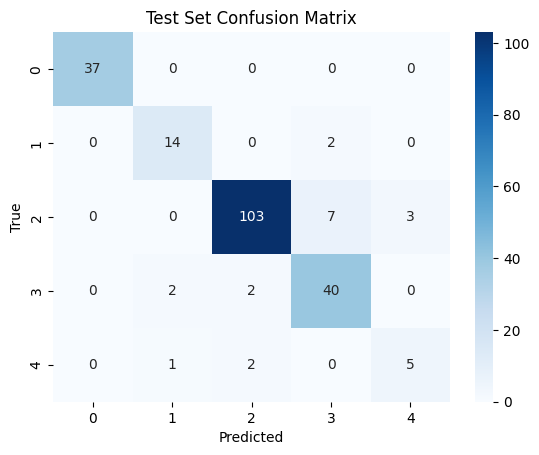

In [20]:
# Model Training Random Forst

# NESTED CROSS-VALIDATION

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_dist = {
    'n_estimators': np.arange(200, 1001, 100),
    'max_depth': [5, 10, 15, None],
    'max_features': ['sqrt', 'log2', 0.5],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

results = []

for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Randomized hyperparameter search
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    search = RandomizedSearchCV(
        rf, param_distributions=param_dist, n_iter=10, cv=inner_cv, 
        scoring='balanced_accuracy', n_jobs=-1
    )
    search.fit(X_tr, y_tr)
    best_rf = search.best_estimator_

    # Evaluate on validation
    y_pred = best_rf.predict(X_val)
    y_proba = best_rf.predict_proba(X_val)
    
    results.append({
        'bal_acc': balanced_accuracy_score(y_val, y_pred),
        'macro_f1': f1_score(y_val, y_pred, average='macro'),
        'roc_auc': roc_auc_score(pd.get_dummies(y_val), y_proba, average='macro', multi_class='ovr')
    })


# FINAL MODEL TRAINING

final_params = search.best_params_
final_rf = RandomForestClassifier(**final_params, random_state=42, n_jobs=-1)
final_rf.fit(X_train, y_train)


# FINAL EVALUATION

y_pred_test = final_rf.predict(X_test)
y_proba_test = final_rf.predict_proba(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred_test))
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_test):.3f}")
print(f"Macro F1-score: {f1_score(y_test, y_pred_test, average='macro'):.3f}")
print(f"ROC-AUC (OvR): {roc_auc_score(pd.get_dummies(y_test), y_proba_test, average='macro', multi_class='ovr'):.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [21]:
#save confusion matrix plot
output_dir = r'C:\Projects\BRCA_ML_Project\images'
os.makedirs(output_dir, exist_ok=True)
cm_path = os.path.join(output_dir, 'confusion_matrix.png')

plt.savefig(cm_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Confusion matrix plot saved to: {cm_path}")

Confusion matrix plot saved to: C:\Projects\BRCA_ML_Project\images\confusion_matrix.png


<Figure size 640x480 with 0 Axes>

In [22]:
# FEATURE IMPORTANCE: GINI & PERMUTATION

from sklearn.inspection import permutation_importance

# Define the gene list used in the model
stable_genes = X_train.columns.tolist()  # all features used in RF

# 1. GINI IMPORTANCE

imp = pd.Series(final_rf.feature_importances_, index=stable_genes).sort_values(ascending=False)
print("Top 20 genes by Gini importance:")
print(imp.head(20))


Top 20 genes by Gini importance:
ESR1       0.151855
MLPH       0.138858
FOXA1      0.080631
KRT14      0.069517
SFRP1      0.048902
FOXC1      0.047396
KRT5       0.045273
UBE2T      0.041298
BIRC5      0.035640
CEP55      0.026455
NAT1       0.024463
ERBB2      0.021507
UBE2C      0.021074
KRT17      0.019387
SLC39A6    0.018619
BCL2       0.017648
GRB7       0.013722
NUF2       0.012378
EXO1       0.011913
RRM2       0.011831
dtype: float64


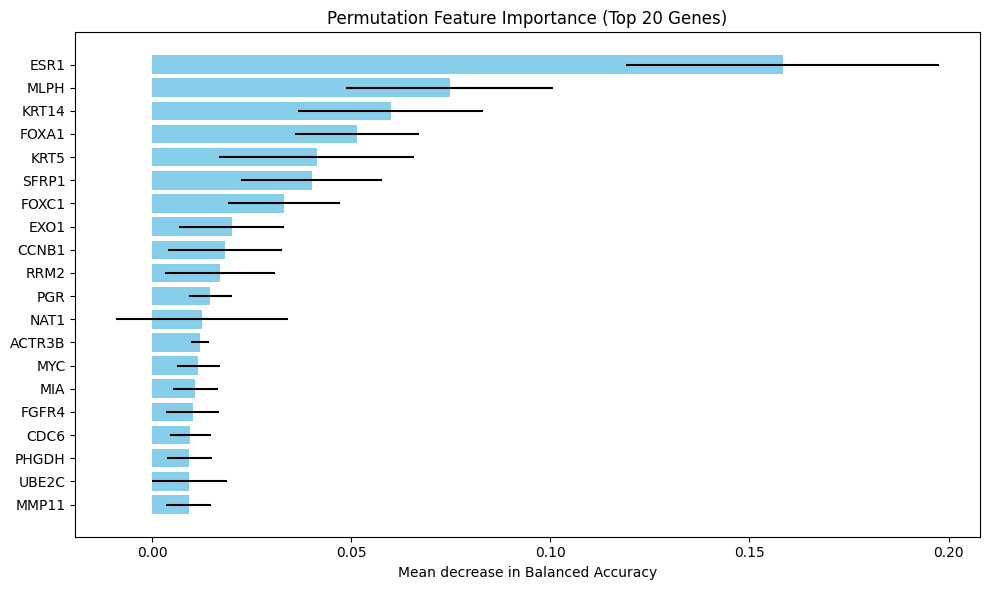

In [23]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Permutation importance on test set
perm_importance = permutation_importance(final_rf, X_test, y_test, 
                                         n_repeats=30, random_state=42, scoring='balanced_accuracy')

# Convert to DataFrame
importance_df = pd.DataFrame({
    'gene': X_test.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

# Plot top 20 genes
plt.figure(figsize=(10,6))
plt.barh(importance_df['gene'][:20][::-1], importance_df['importance_mean'][:20][::-1], 
         xerr=importance_df['importance_std'][:20][::-1], color='skyblue')
plt.xlabel('Mean decrease in Balanced Accuracy')
plt.title('Permutation Feature Importance (Top 20 Genes)')
plt.tight_layout()
plt.show()

In [24]:
# Permutation importance ranking
importance_df['rank'] = range(1, len(importance_df) + 1)

print("Top 20 Genes by Permutation Importance:")
print("="*50)
for i, row in importance_df.head(20).iterrows():
    print(f"{row['rank']:2d}. {row['gene']:20s} | Importance: {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")

Top 20 Genes by Permutation Importance:
 1. ESR1                 | Importance: 0.1583 ± 0.0392
 2. MLPH                 | Importance: 0.0747 ± 0.0260
 3. KRT14                | Importance: 0.0599 ± 0.0232
 4. FOXA1                | Importance: 0.0515 ± 0.0157
 5. KRT5                 | Importance: 0.0413 ± 0.0245
 6. SFRP1                | Importance: 0.0401 ± 0.0177
 7. FOXC1                | Importance: 0.0330 ± 0.0141
 8. EXO1                 | Importance: 0.0200 ± 0.0132
 9. CCNB1                | Importance: 0.0184 ± 0.0143
10. RRM2                 | Importance: 0.0172 ± 0.0138
11. PGR                  | Importance: 0.0146 ± 0.0054
12. NAT1                 | Importance: 0.0126 ± 0.0216
13. ACTR3B               | Importance: 0.0121 ± 0.0023
14. MYC                  | Importance: 0.0116 ± 0.0054
15. MIA                  | Importance: 0.0109 ± 0.0056
16. FGFR4                | Importance: 0.0102 ± 0.0067
17. CDC6                 | Importance: 0.0096 ± 0.0052
18. PHGDH                

Heatmap plot saved to: C:\Projects\BRCA_ML_Project\images\top20_genes_heatmap.png


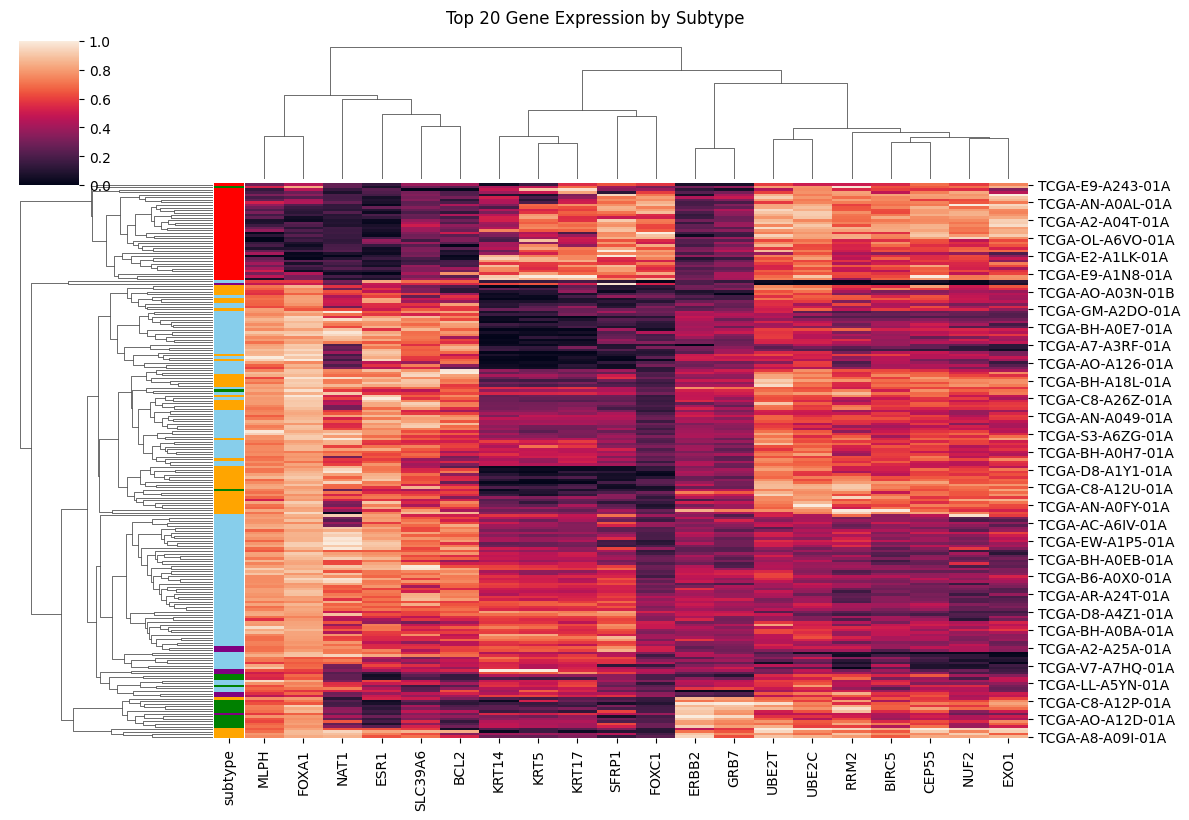

In [28]:
# Top 20 genes
top_genes = imp.head(20).index.tolist()  # or perm_df['gene'][:20]
X_heatmap = X_test[top_genes].copy()
X_heatmap['subtype'] = y_test

# Sort samples by subtype
X_heatmap_sorted = X_heatmap.sort_values('subtype')

# Row colors for subtypes
row_colors = X_heatmap_sorted['subtype'].map({
    'LumA': 'skyblue', 
    'LumB': 'orange', 
    'Basal': 'red', 
    'HER2E': 'green', 
    'Normal': 'purple'
})

# Create clustermap
cg = sns.clustermap(
    X_heatmap_sorted[top_genes],
    row_colors=row_colors,
    standard_scale=1,
    figsize=(12,8)
)

# Set title correctly
cg.fig.suptitle("Top 20 Gene Expression by Subtype", y=1.02)

# Ensure output directory exists
output_dir = r'C:\Projects\BRCA_ML_Project\images'
os.makedirs(output_dir, exist_ok=True)

# Save the figure
heatmap_path = os.path.join(output_dir, 'top20_genes_heatmap.png')
cg.savefig(heatmap_path, dpi=300, bbox_inches='tight', facecolor='white')

print(f"Heatmap plot saved to: {heatmap_path}")

# Display
plt.show()


Model classes: ['Basal' 'HER2E' 'LumA' 'LumB' 'Normal']
Number of classes: 5
X_test shape: (218, 48)
Creating SHAP explainer...
SHAP values type: <class 'shap._explanation.Explanation'>
SHAP values shape: (218, 48, 5)
Detected new SHAP output format
SHAP array shape: (218, 48, 5)
Multi-class SHAP structure detected

Top 20 features by SHAP importance:
    feature  mean_abs_shap
16     ESR1       0.079141
32     MLPH       0.054733
19    FOXA1       0.033752
24    KRT14       0.024188
47    UBE2T       0.018542
43    SFRP1       0.018190
20    FOXC1       0.017485
26     KRT5       0.015575
4     BIRC5       0.014717
36     NAT1       0.013358
12    CEP55       0.011850
46    UBE2C       0.010747
25    KRT17       0.009089
44  SLC39A6       0.008533
15    ERBB2       0.007410
3      BCL2       0.007193
42     RRM2       0.006090
17     EXO1       0.005392
38     NUF2       0.005130
27     MAPT       0.004754

Generating SHAP plots...
SHAP values type: <class 'shap._explanation.Explanati

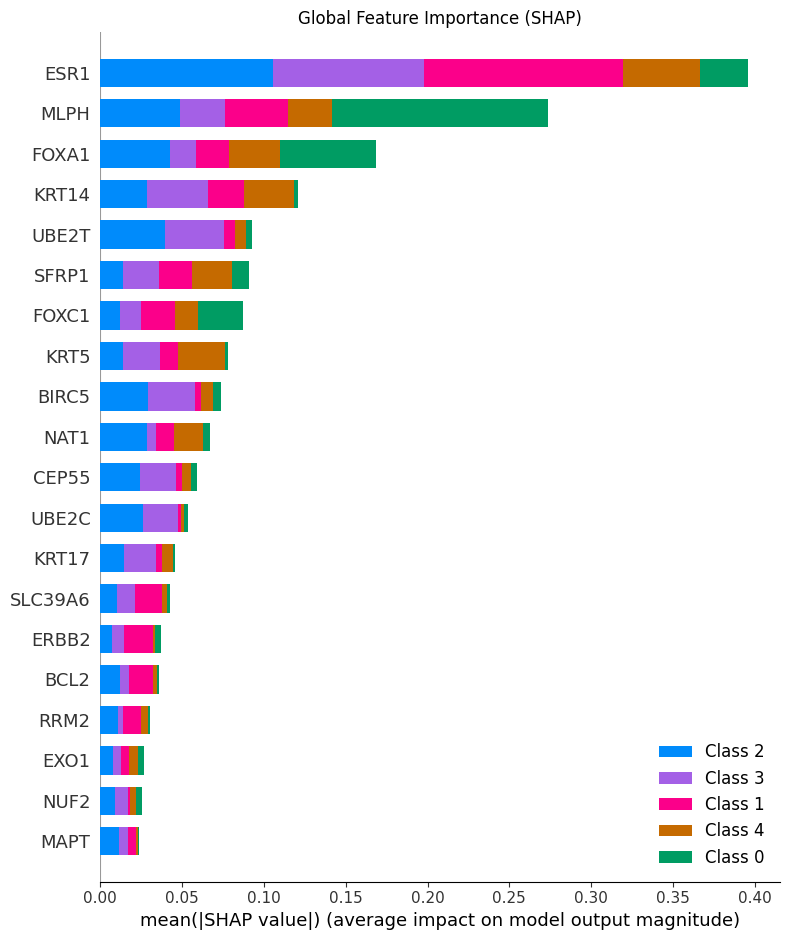

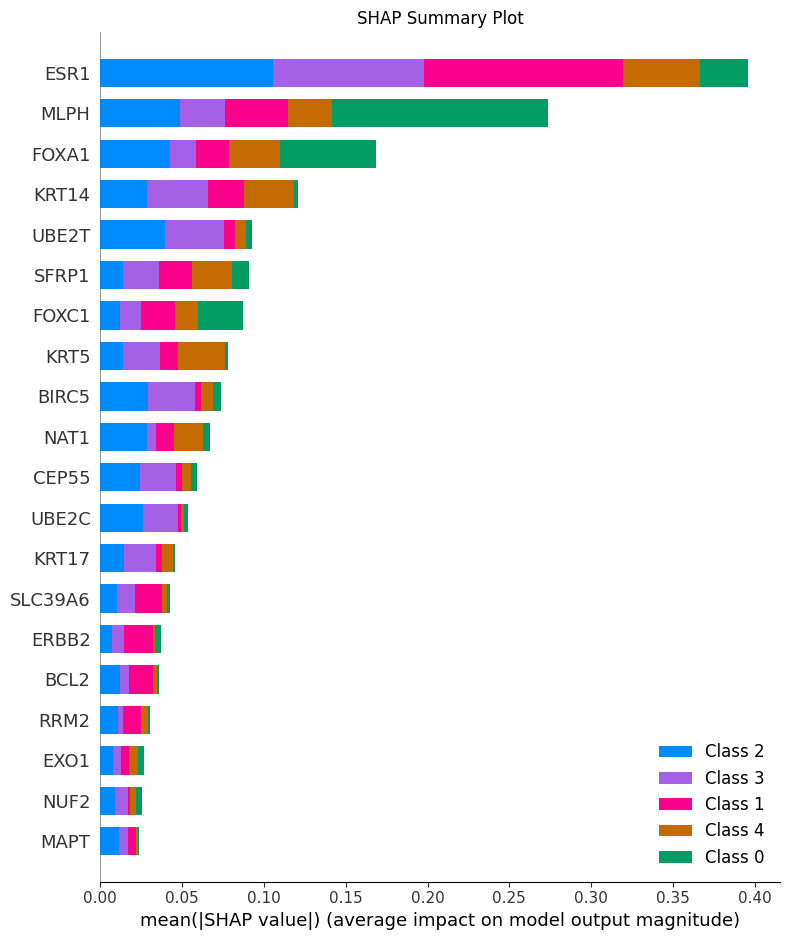


Multi-class detected (5 classes), generating per-class plots...
Generating plot for class: Basal


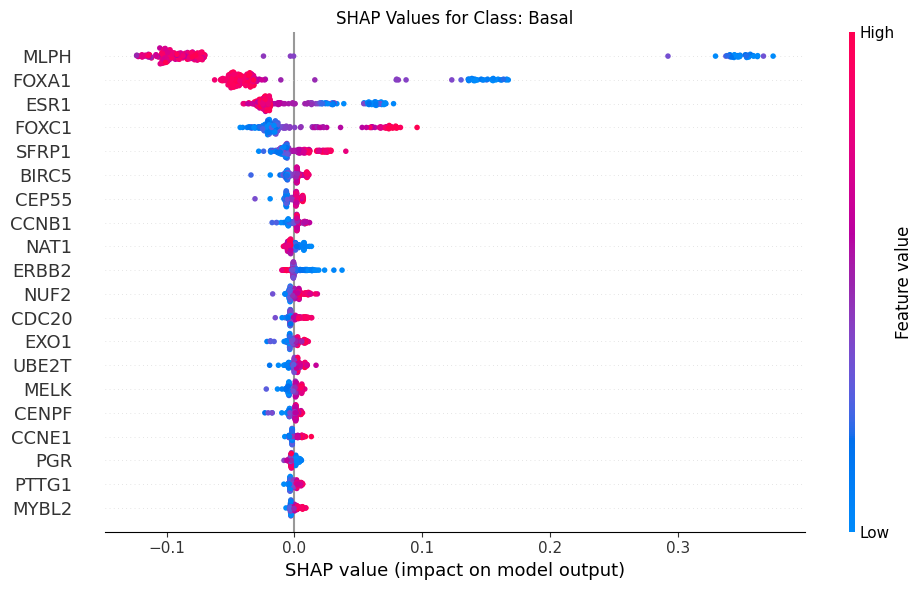

Generating plot for class: HER2E


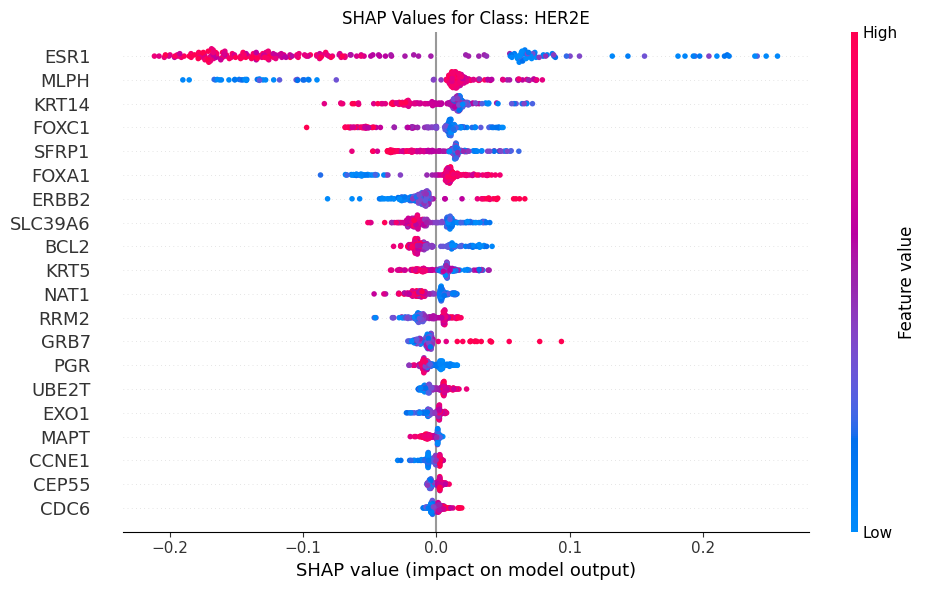

Generating plot for class: LumA


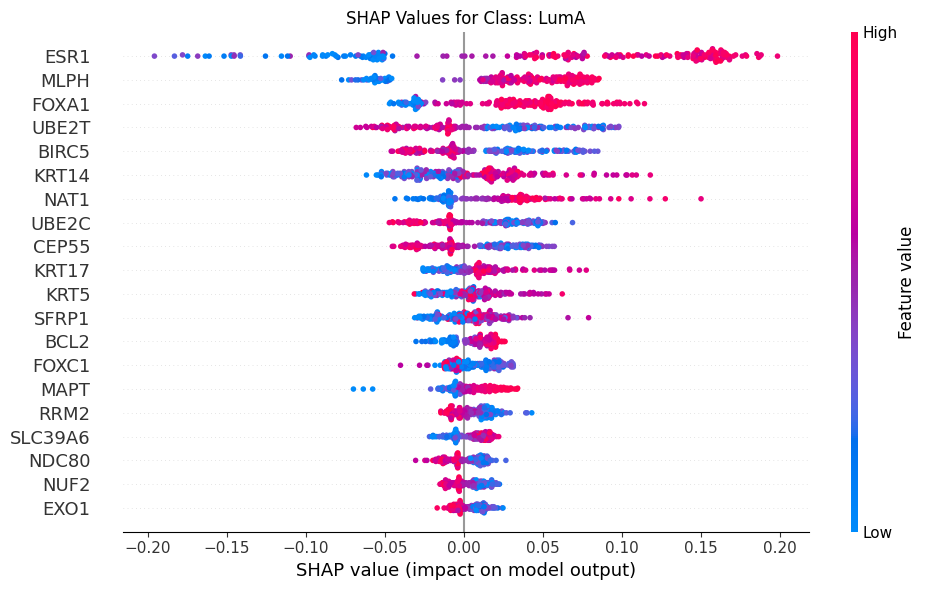

Generating plot for class: LumB


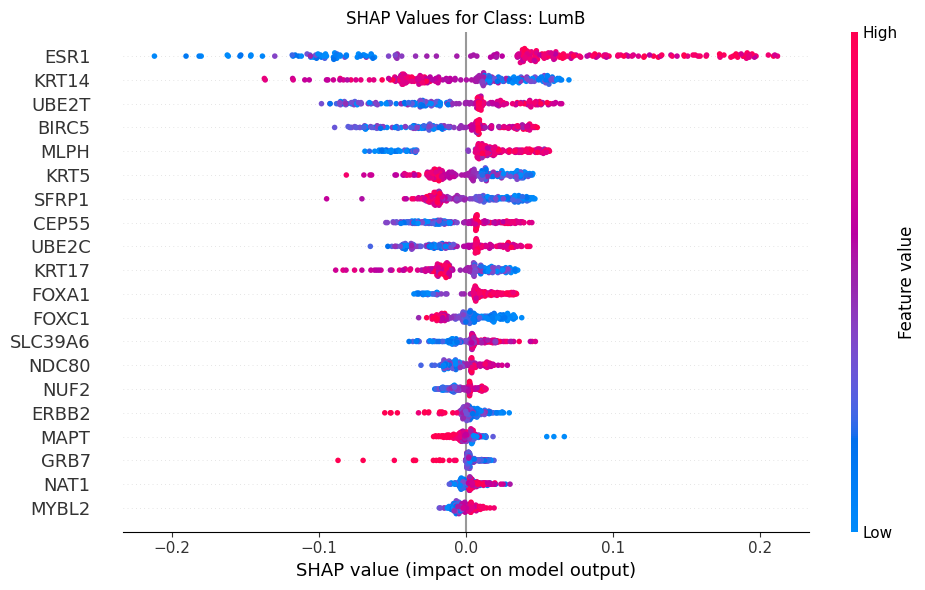

Generating plot for class: Normal


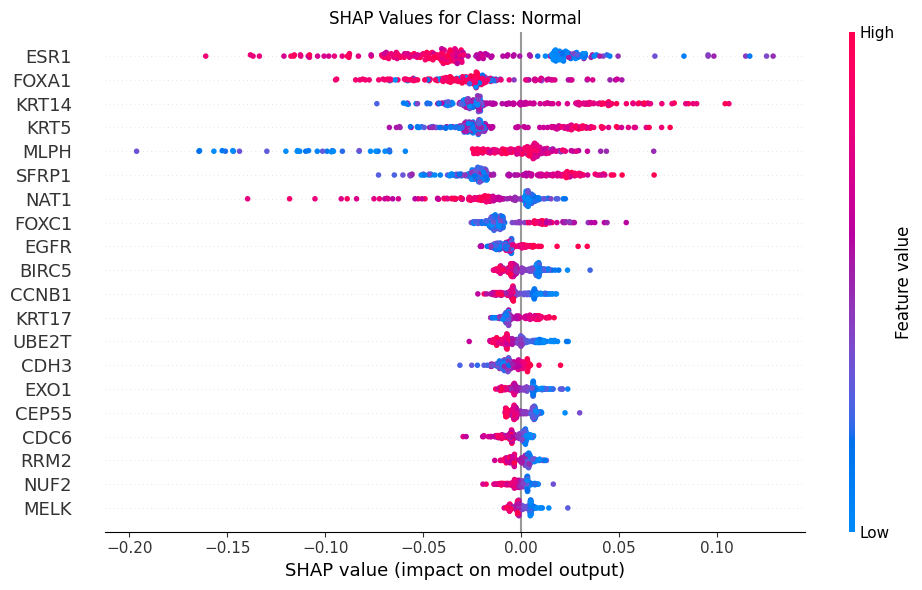


 Comparing SHAP importance with Random Forest native importance...
Top 10 features comparison:
   feature  shap_importance  rf_importance
16    ESR1         0.079141       0.151855
32    MLPH         0.054733       0.138858
19   FOXA1         0.033752       0.080631
24   KRT14         0.024188       0.069517
47   UBE2T         0.018542       0.041298
43   SFRP1         0.018190       0.048902
20   FOXC1         0.017485       0.047396
26    KRT5         0.015575       0.045273
4    BIRC5         0.014717       0.035640
36    NAT1         0.013358       0.024463


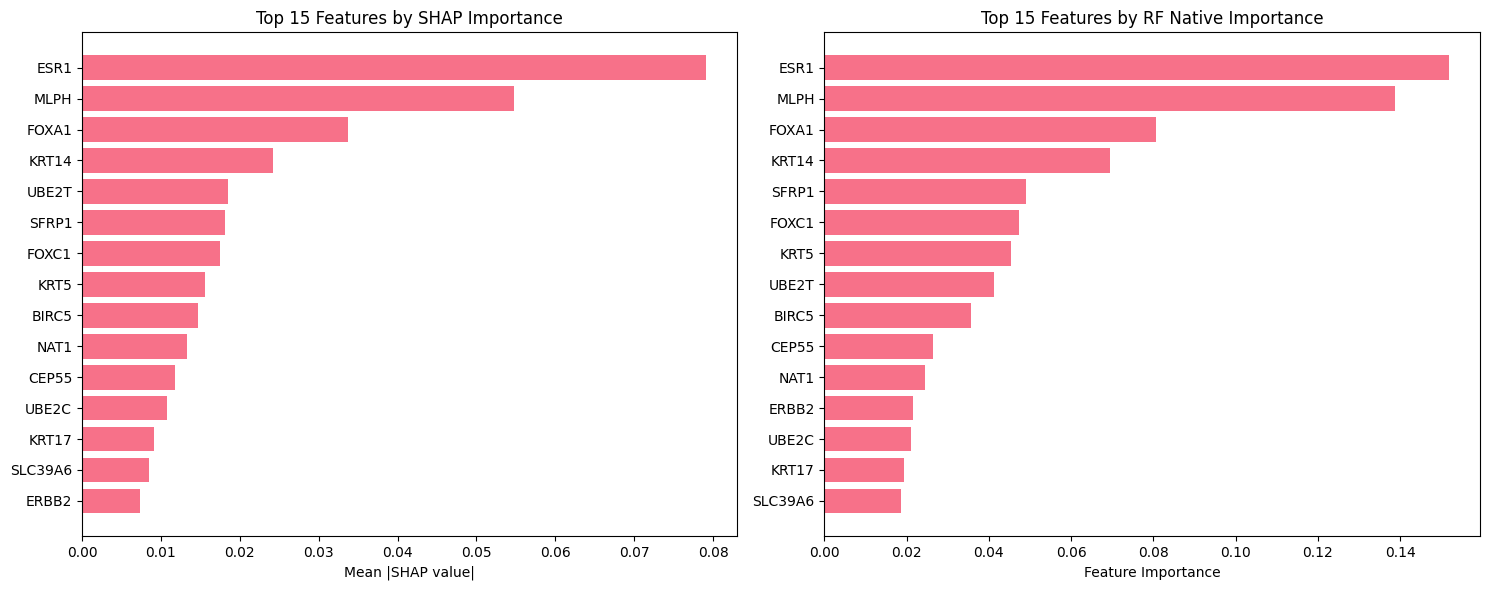

SHAP analysis completed successfully!


In [29]:
# SHAP EXPLANATION FOR RANDOM FOREST - FIXED VERSION

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure we have feature names
if 'stable_genes' not in locals():
 
    stable_genes = [f'Feature_{i}' for i in range(X_test.shape[1])]

# Create DataFrame for better visualization
X_test_df = pd.DataFrame(X_test, columns=stable_genes)

print(f"Model classes: {final_rf.classes_}")
print(f"Number of classes: {len(final_rf.classes_)}")
print(f"X_test shape: {X_test.shape}")

# Create TreeExplainer
print("Creating SHAP explainer...")
explainer = shap.TreeExplainer(final_rf)

# Get SHAP values - let's check what structure we get
shap_values = explainer(X_test_df)

print(f"SHAP values type: {type(shap_values)}")
print(f"SHAP values shape: {getattr(shap_values, 'shape', 'No shape attribute')}")

# Handle different SHAP output structures
if hasattr(shap_values, 'values'):
    # Newer SHAP version (object with .values attribute)
    print("Detected new SHAP output format")
    shap_array = shap_values.values
    print(f"SHAP array shape: {shap_array.shape}")
    
    if len(shap_array.shape) == 3:
        # Multi-class case: (n_samples, n_features, n_classes)
        print("Multi-class SHAP structure detected")
        
        # Compute global importance (mean absolute SHAP across all classes and samples)
        shap_abs = np.abs(shap_array)  # (n_samples, n_features, n_classes)
        shap_mean = shap_abs.mean(axis=(0, 2))  # (n_features,)
        
    else:
        # Binary case or other structure
        print(f"Unexpected SHAP shape: {shap_array.shape}")
        shap_mean = np.abs(shap_array).mean(axis=0)
        
else:
    # Older SHAP version (list of arrays)
    print("Detected old SHAP output format (list)")
    print(f"Number of SHAP arrays: {len(shap_values)}")
    
    # Check each array
    for i, sv in enumerate(shap_values):
        print(f"SHAP values[{i}] shape: {sv.shape}")
    
    # Convert to numpy array and compute importance
    shap_array = np.array(shap_values)  # (n_classes, n_samples, n_features) or (n_samples, n_features)
    print(f"Combined SHAP array shape: {shap_array.shape}")
    
    if len(shap_array.shape) == 3:
        # (n_classes, n_samples, n_features)
        shap_abs = np.abs(shap_array)
        shap_mean = shap_abs.mean(axis=(0, 1))  # (n_features,)
    else:
        # (n_samples, n_features) - binary case
        shap_mean = np.abs(shap_array).mean(axis=0)

# Create SHAP importance DataFrame
shap_df = pd.DataFrame({
    'feature': stable_genes,
    'mean_abs_shap': shap_mean
}).sort_values('mean_abs_shap', ascending=False)

print("\nTop 20 features by SHAP importance:")
print(shap_df.head(20))


# SHAP SUMMARY PLOTS

print("\nGenerating SHAP plots...")

try:
    # Plot 1: Bar plot of feature importance
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
    plt.title("Global Feature Importance (SHAP)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Bar plot failed: {e}")

try:
    # Plot 2: Beeswarm plot for overall patterns
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_df, show=False)
    plt.title("SHAP Summary Plot")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Beeswarm plot failed: {e}")


# PER-CLASS ANALYSIS (if multi-class)

if len(final_rf.classes_) > 2:
    print(f"\nMulti-class detected ({len(final_rf.classes_)} classes), generating per-class plots...")
    
    try:
        # For multi-class, create one plot per class
        for i, class_name in enumerate(final_rf.classes_):
            print(f"Generating plot for class: {class_name}")
            
            plt.figure(figsize=(10, 6))
            
            # Extract SHAP values for this class
            if hasattr(shap_values, 'values') and len(shap_array.shape) == 3:
                # New format: (n_samples, n_features, n_classes)
                class_shap = shap_array[:, :, i]
            else:
                # Old format: (n_classes, n_samples, n_features)
                class_shap = shap_array[i]
            
            # Create DataFrame for this class's SHAP values
            class_shap_df = pd.DataFrame(class_shap, columns=stable_genes)
            
            # Plot for this class
            shap.summary_plot(class_shap, X_test_df, show=False, plot_size=(10, 6))
            plt.title(f"SHAP Values for Class: {class_name}")
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Per-class plots failed: {e}")

# FEATURE IMPORTANCE COMPARISON

print("\n Comparing SHAP importance with Random Forest native importance...")

# Get native feature importance from Random Forest
rf_importance = final_rf.feature_importances_

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'feature': stable_genes,
    'shap_importance': shap_mean,
    'rf_importance': rf_importance
}).sort_values('shap_importance', ascending=False)

print("Top 10 features comparison:")
print(comparison_df.head(10))

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# SHAP importance
top_shap = comparison_df.head(15)
ax1.barh(range(len(top_shap)), top_shap['shap_importance'][::-1])
ax1.set_yticks(range(len(top_shap)))
ax1.set_yticklabels(top_shap['feature'][::-1])
ax1.set_title('Top 15 Features by SHAP Importance')
ax1.set_xlabel('Mean |SHAP value|')

# RF native importance
top_rf = comparison_df.sort_values('rf_importance', ascending=False).head(15)
ax2.barh(range(len(top_rf)), top_rf['rf_importance'][::-1])
ax2.set_yticks(range(len(top_rf)))
ax2.set_yticklabels(top_rf['feature'][::-1])
ax2.set_title('Top 15 Features by RF Native Importance')
ax2.set_xlabel('Feature Importance')

plt.tight_layout()
plt.show()

print("SHAP analysis completed successfully!")

In [30]:
# SAVE MODEL ONLY 

import joblib

# Save the model
output_dir = r'C:\Projects\BRCA_ML_Project\Data\Output'
os.makedirs(output_dir, exist_ok=True)

model_path = os.path.join(output_dir, 'random_forest_model.pkl')
joblib.dump(final_rf, model_path)

print(f"Model saved successfully.to: {model_path}")

Model saved successfully.to: C:\Projects\BRCA_ML_Project\Data\Output\random_forest_model.pkl
